# 1. Импорт и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series

temp_df = pd.read_csv("C:\\Users\\Лев\\Projects\\Diploma\\sbp2.csv", sep=';')
temp_df['time'] = pd.to_datetime(temp_df['time'], dayfirst=True)
temp_df = temp_df.sort_values(by=['time'])
temp = pd.DataFrame(pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h'), columns=['time'])
temp = temp.set_index('time').join(temp_df.set_index('time'), how='left')
temp = temp['T'].ffill()
temp.index = pd.date_range(start=temp_df['time'][55215], end=temp_df['time'][0], freq='3 h')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='T'>)

<Figure size 1500x500 with 0 Axes>

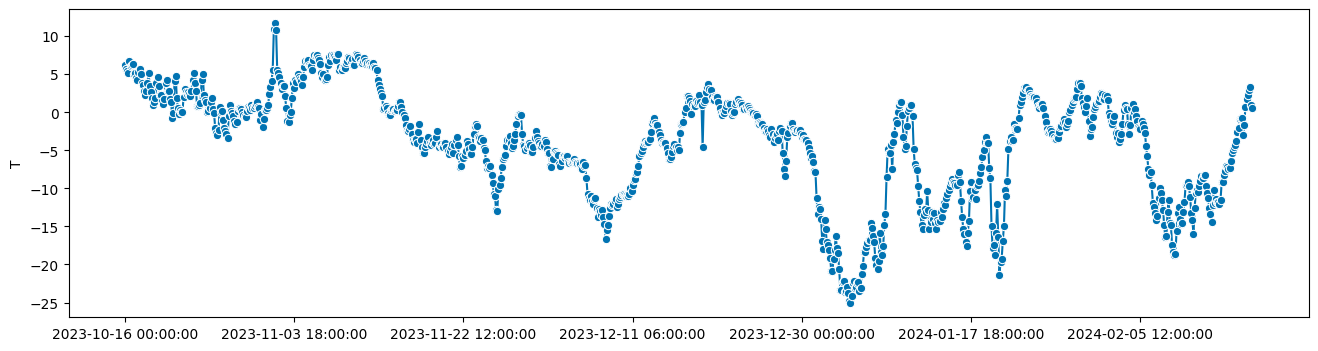

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plot_series(temp[-1000:])

In [22]:
def l2_improved(y_true, y_pred, start_index):
    if len(y_pred) != len(y_true):
        print("Lenghts are not the same!")
        return 0
    hour_vars = [0.770578, 0.727813, 0.729499, 0.885727, 0.982857, 0.999754, 1.000000, 0.883696]
    s = 0
    n = len(y_true)
    for i in range(n):
        s += (y_true[i] - y_pred[i]) ** 2 / hour_vars[(start_index + i) % 8]
    return s / n

52504 2920


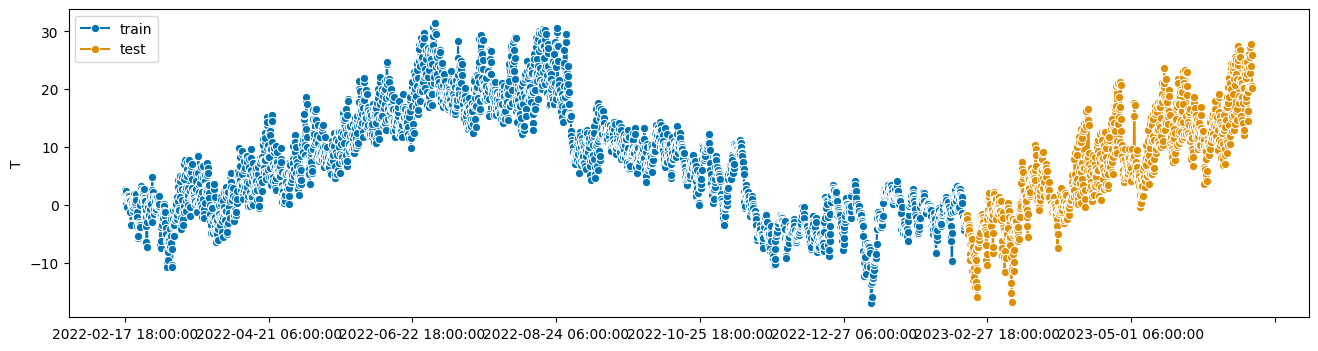

In [4]:
from sktime.forecasting.model_selection import temporal_train_test_split

temp_train, temp_test = temporal_train_test_split(temp, test_size=2920)
plot_series(temp_train[-2922:], temp_test[:1000], labels=['train', 'test'])
print(temp_train.shape[0], temp_test.shape[0])

In [5]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(temp_test.index, is_relative=False)

# Наивный прогноз

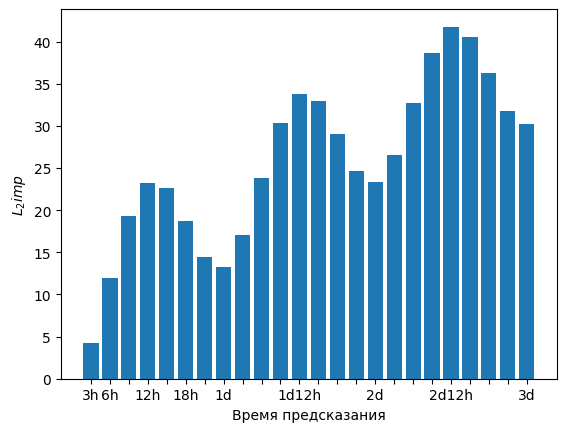

In [24]:
maes = [l2_improved(temp_test[i:].values, temp_test[:-i].values, int(temp_test.index[i].hour / 3)) for i in range(1, 25)]

import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes)
plt.xlabel("Время предсказания")
plt.ylabel("$L_2 imp$")
plt.show()

# ETS модель (без тренда) - наивная + сезонность

In [25]:
# 52504
day_diff = [np.mean([temp_train[8 * i + j + 1] - temp_train[8 * i + j] for i in range(1, 6560)]) for j in range(8)]
day_diff

C:\Users\Лев\AppData\Local\Temp\ipykernel_12120\2289646946.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  day_diff = [np.mean([temp_train[8 * i + j + 1] - temp_train[8 * i + j] for i in range(1, 6560)]) for j in range(8)]


[-0.687116938557707,
 -0.3238450983381614,
 1.2071657264826954,
 1.6168470803476143,
 0.8885043451745691,
 -0.3664735477969202,
 -1.2268638511968288,
 -1.1062966915688366]

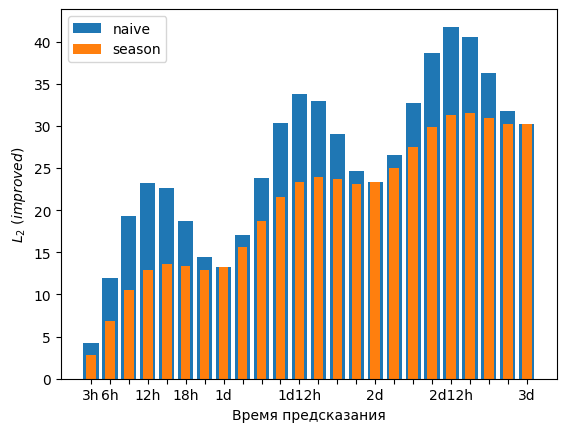

In [30]:
maes_s = []
temp_test_predict = temp_test.values.copy()
for i in range(24):
    for j in range(len(temp_test_predict)):
        temp_test_predict[j] += day_diff[(j + i) % 8]
    maes_s.append(l2_improved(temp_test_predict[:-(i + 1)], temp_test[(i + 1):].values, int(temp_test.index[i + 1].hour // 3)))


import matplotlib.pyplot as plt

names=['3h','6h','               ','12h','              ','18h','             ','1d','            ','           ','          ','1d12h','         ','        ','       ','2d', ' ','  ','   ','2d12h','    ','     ','      ','3d']
plt.bar(x=names, height=maes, label='naive')
plt.bar(x=names, width=0.5,height=maes_s, label='season')
plt.xlabel("Время предсказания")
plt.ylabel("$L_2 \\ (improved)$")
plt.legend()
plt.show()